# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.



## Потребление энергии

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings
import itertools

warnings.filterwarnings("ignore")

In [2]:
energy_data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

energy_data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
energy_data_per_month = energy_data.resample('M').mean()

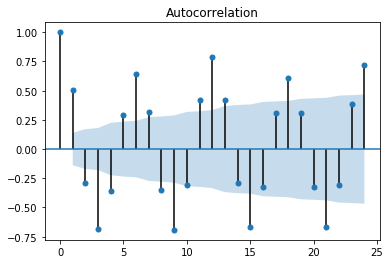

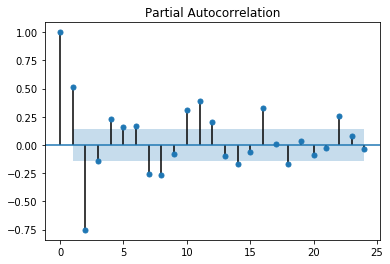

In [4]:
sm.graphics.tsa.plot_acf(energy_data_per_month['PJME_MW'].values, lags=24)
plt.show()
sm.graphics.tsa.plot_pacf(energy_data_per_month['PJME_MW'].values, lags=24)
plt.show()

По граифку автокоррелляции видно, что данные повторяются раз в 12 месяцев. Учтем это как период сезонности. График частичной автокоррелляции показывает, что значимость есть только при глубине 2 месяца. Сформируем начальные признаки и посчитаем модель.

In [5]:
q = 2
p = 1
d = 2
pdq = [p, d, q]

qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs, 12] 

In [6]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [7]:
mod = sm.tsa.statespace.SARIMAX(energy_data_per_month['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 0, 1, 12] - AIC:3204.054461059828


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 0, 1, 12)   Log Likelihood               -1597.027
Date:                            Wed, 13 May 2020   AIC                           3204.054
Time:                                    21:38:35   BIC                           3219.763
Sample:                                         0   HQIC                          3210.428
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

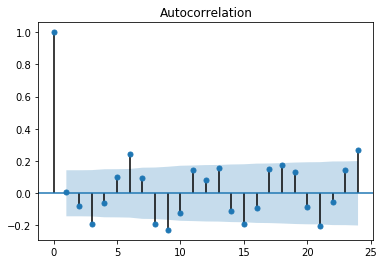

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

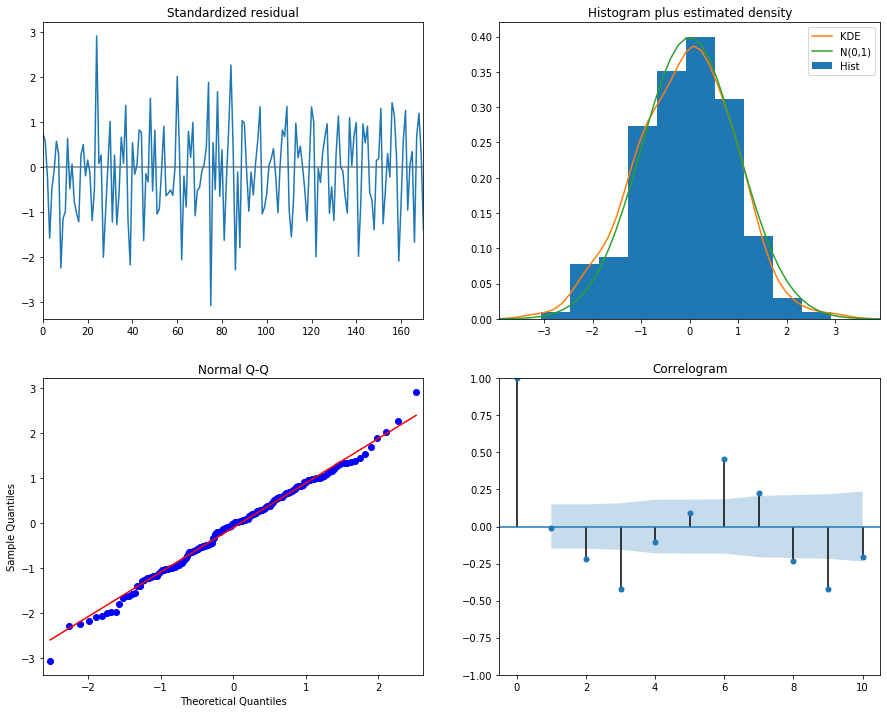

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

По графикам видно, что модель еще можно оптимизировать. Попробуем подобрать параметры точнее.

In [11]:
p = d = range(0, 2)
q = [1, 3, 6]

pdq = list(itertools.product(p, d, q))

p = [0, 1] 
d = [0, 1]
q = range(0, 4)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 3) x (0, 0, 1, 12)
SARIMAX: (0, 0, 3) x (0, 0, 0, 12)
SARIMAX: (0, 0, 6) x (0, 0, 0, 12)
SARIMAX: (0, 0, 6) x (0, 0, 1, 12)


In [12]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(energy_data_per_month['PJME_MW'].values[:-36],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results_ = mod.fit()
            
            if results_.aic < min_aic:
                min_aic = results_.aic
                print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results_.aic))
        except:
            continue

ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC: 3712.755773697847
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC: 3410.853563782917
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC: 2674.393566096244
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC: 2454.520959792658
ARIMA(0, 0, 1)x(0, 1, 2, 12) - AIC: 2223.927896464961
ARIMA(0, 0, 1)x(0, 1, 3, 12) - AIC: 1997.4268372835672
ARIMA(0, 0, 3)x(0, 1, 3, 12) - AIC: 1969.8778201797304
ARIMA(0, 0, 6)x(1, 1, 3, 12) - AIC: 1915.165491985138
ARIMA(0, 1, 6)x(1, 1, 3, 12) - AIC: 1897.7038713793056
ARIMA(1, 1, 6)x(0, 1, 3, 12) - AIC: 1896.6240983413752


Лучшие результаты на недельных данных параметры модели ARIMA(1, 1, 6)x(0, 1, 3, 12) - AIC: 1896.6240983413752

In [13]:
mod = sm.tsa.statespace.SARIMAX(energy_data_per_month['PJME_MW'].values[:-36],order=[1,1,6],
                                seasonal_order=[0,1,3,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC: {results_opt.aic}')

AIC: 1896.6240983413752


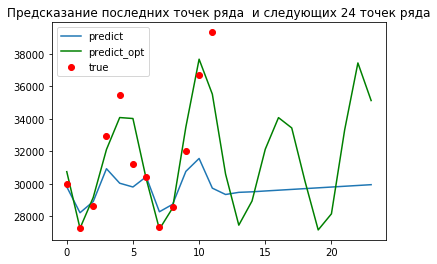

In [14]:
pred_dynamic = results.forecast(24)
pred_dynamic_opt = results_opt.forecast(24)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )

plt.plot(energy_data_per_month['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 24 точек ряда')
plt.legend()

plt.show()

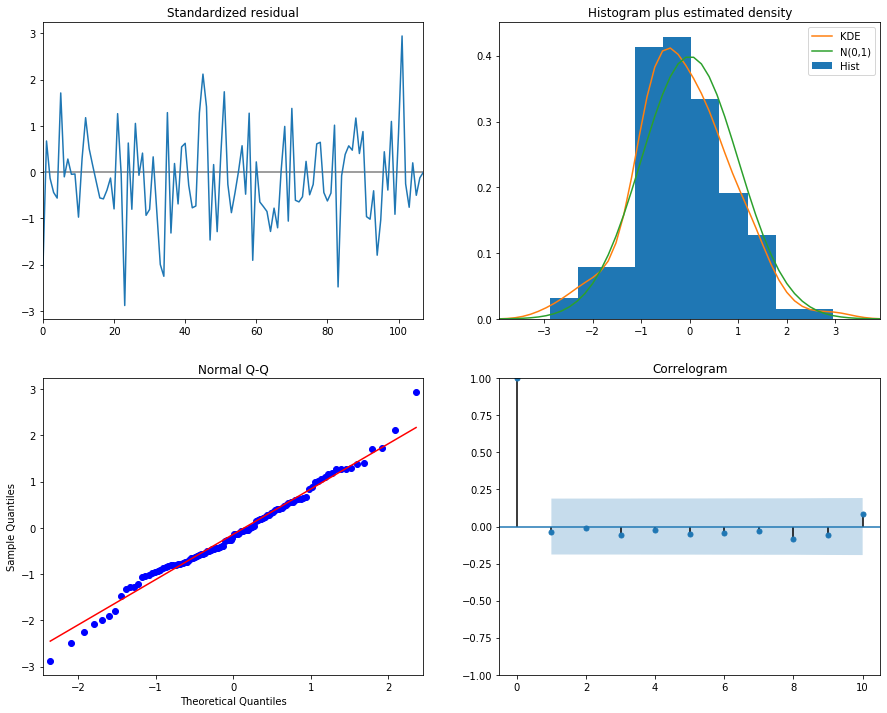

In [15]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

Улучшеная модель ближе к точкам выборки на отрезке предсказания. Однако общий результат моделирования еще далек от идеала. Проверим остатки модели.

In [16]:
from sklearn.metrics import r2_score 
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-7.825187093705877, 6.510141279129046e-12, 2, 161, {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}, 2627.162920966054)


ADF тест (adf_test[1] = 0) показывает, что пока остатки являются стационарным рядом,и хотя модель требует доработки, она отвечает на вопрос о поведении ряда во времени. Это значит, что можно уверенно прогнозировать - значения модели в диапазоне дисперсии остатков.  

По сравнению с прогназированием на недельных данных, месячные данные выглядят грубее, но в йелом неплохо следуют за сезонностью.

## 4
 Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )
    https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv тут можно скачать актуальные данные. Дополнительно прикрепила датасет к материалам


## 5 
Оцените результат моделирования

Выбрал COVID, тема актуальная нынче.

In [17]:
covid = pd.read_csv('COVID-19/covid_19_data.csv', index_col=[1], parse_dates=[1])

In [18]:
covid.tail()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-05-10,23477,Wyoming,US,2020-05-11 02:32:30,662.0,7.0,0.0
2020-05-10,23478,Xinjiang,Mainland China,2020-05-11 02:32:30,76.0,3.0,73.0
2020-05-10,23479,Yukon,Canada,2020-05-11 02:32:30,11.0,0.0,0.0
2020-05-10,23480,Yunnan,Mainland China,2020-05-11 02:32:30,185.0,2.0,183.0
2020-05-10,23481,Zhejiang,Mainland China,2020-05-11 02:32:30,1268.0,1.0,1267.0


In [19]:
# covid = covid.loc[covid['Country/Region']=='Russia']
# covid.tail()

Решил не брать какую то отдельную страну, а посмотреть на данные по всему миру. За мир во всем мире.

Сгруппируем по всем подтвержденным случаям по суточно.

In [20]:
covid = covid.groupby(['ObservationDate']).sum().sort_values('Confirmed', ascending=True)
covid.tail(10)

,SNo,Confirmed,Deaths,Recovered
ObservationDate,,,,
2020-05-01,6593399,3343777.0,238650.0,1053327.0
2020-05-02,6697728,3427343.0,243808.0,1093112.0
2020-05-03,6802057,3506729.0,247470.0,1125236.0
2020-05-04,6906386,3583055.0,251537.0,1162724.0
2020-05-05,7010715,3662691.0,257239.0,1198832.0
2020-05-06,7115044,3755341.0,263831.0,1245413.0
2020-05-07,7219373,3845718.0,269567.0,1284741.0
2020-05-08,7323702,3938064.0,274898.0,1322050.0
2020-05-09,7428031,4024009.0,279311.0,1375624.0


Возьмем первые разности. Так мы получим ежедневнй прирост случаев заражения во всем мире.

In [21]:
covid = pd.DataFrame(covid.Confirmed.diff().values[1:], index=covid.index[1:], columns=['Confirmed'])

In [22]:
covid.head(10)

,Confirmed
ObservationDate,
2020-01-23,98.0
2020-01-24,288.0
2020-01-25,497.0
2020-01-26,680.0
2020-01-27,809.0
2020-01-28,2651.0
2020-01-29,587.0
2020-01-30,2070.0
2020-01-31,1690.0


Построим более красивый график по изменениям суточных приростов.

In [23]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines+markers',
            name = column
            
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Дополнительно добавим признаки. __trend_mean__ показывает как изменяется среднее суточное значение с пересчетом на каждый день. Это своего рода тренд прироста. __trend_std__ показывает как меняется скорость прироста, чем меньше угол к оси X, тем выше вероятность плато(у нас то давно оно. нет)

In [24]:
mean_covid = []
std_covid = []

for i in covid.index:
    mean_covid.append(np.mean(covid[:i].values))
    std_covid.append(np.std(covid[:i].values))
    
covid['trend_mean'] = mean_covid
covid['trend_std'] = std_covid

In [25]:
plotly_df(covid, title = 'Число зараженных ежесуточно в мире')

Проверим ряд на стационарность. Затем разности до 3 порядка.

In [26]:
adf_covid = sm.tsa.stattools.adfuller(covid['Confirmed'].values,regression='ctt')
print('p-value = ', adf_covid[1])

p-value =  0.9658562890715298


Исходный ряд не стационарен.

In [27]:
covid_diff = pd.DataFrame(covid.diff().iloc[1:,0], index=covid.index[1:], columns=['Confirmed'])

In [28]:
adf_covid_diff = sm.tsa.stattools.adfuller(covid_diff['Confirmed'].values,regression='ctt')
print('p-value = ', adf_covid_diff[1])

p-value =  0.3279366832628777


Первые разности не стационарны.

In [29]:
covid_diff_2 = pd.DataFrame(covid.diff(periods=2).iloc[2:,0], index=covid.index[2:], columns=['Confirmed'])

In [30]:
adf_covid_diff_2 = sm.tsa.stattools.adfuller(covid_diff_2['Confirmed'].values,regression='ctt')

print('p-value = ', adf_covid_diff_2[1])

p-value =  0.2823468401822474


Разности 2 порядка не стационарны.

In [31]:
covid_diff_3 = pd.DataFrame(covid.diff(periods=3).iloc[3:,0], index=covid.index[3:], columns=['Confirmed'])

In [32]:
adf_covid_diff_3 = sm.tsa.stattools.adfuller(covid_diff_3['Confirmed'].values,regression='ctt')

print('p-value = ', adf_covid_diff_3[1])

p-value =  0.25096047411078126


Разности 3 порядка не стационарны.

Отдельно нарисуем первые разности и дополнительные параметры. __trend_mean__ показывает как изменяется скорость прироста, то есть своего рода ускорение прироста. С середины марта __trend_mean__ отклоняется от нуля, что соответствует всплеску выявления новых случаев заражений по всему миру. __trend_std__ говорит о том, что скорость прироста нелинейна, что соответствет сначала резкому росту, а затем колебаниям показателя числа новых случаев заражения вирусом.

In [33]:
mean_covid = []
std_covid = []

for i in covid_diff.index:
    mean_covid.append(np.mean(covid_diff[:i].values))
    std_covid.append(np.std(covid_diff[:i].values))
    
covid_diff['trend_mean'] = mean_covid
covid_diff['trend_std'] = std_covid

In [34]:
plotly_df(covid_diff, title = 'Первые разности числа зараженных ежесуточно в мире')

Исходя из всего это можно сказать только одно: сегодня в завтрашний день не все могут смотреть. 
Вернее смотреть могут не только лишь все, мало кто может это делать

Попробуем таки построить модель. Для начала нарисуем графики автокоррелляции и частичной автокоррелляции.

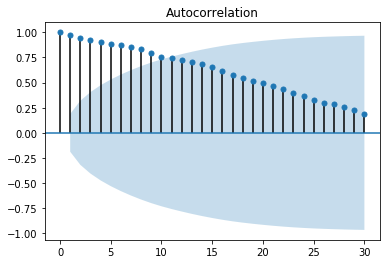

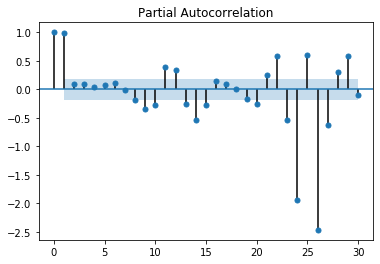

In [35]:
sm.graphics.tsa.plot_acf(covid['Confirmed'].values, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(covid['Confirmed'].values, lags=30)
plt.show()

Сезонности нет, q можно проовать брать примерно до 7, p - 1. Попробуем выбрать случайные параметры. Сезонности хоть и нет, но укажем ее равной 7 дней, чтобы попробовать учесть восходящий тренд.

In [36]:
q = 2
p = 1
d = 2
pdq = [p, d, q]

qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs, 7] 

In [37]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 7]


In [38]:
mod = sm.tsa.statespace.SARIMAX(covid['Confirmed'].values[:-14],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 0, 1, 7] - AIC:1732.199391547784


In [39]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   95
Model:             SARIMAX(1, 2, 2)x(0, 0, 1, 7)   Log Likelihood                -861.100
Date:                           Wed, 13 May 2020   AIC                           1732.199
Time:                                   21:47:24   BIC                           1744.294
Sample:                                        0   HQIC                          1737.058
                                            - 95                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

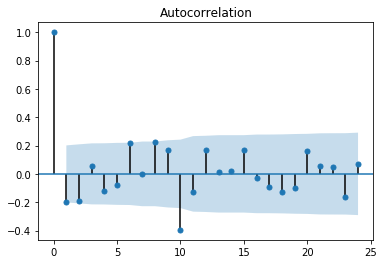

In [40]:
sm.graphics.tsa.plot_acf(results.resid, lags=24)
plt.show()

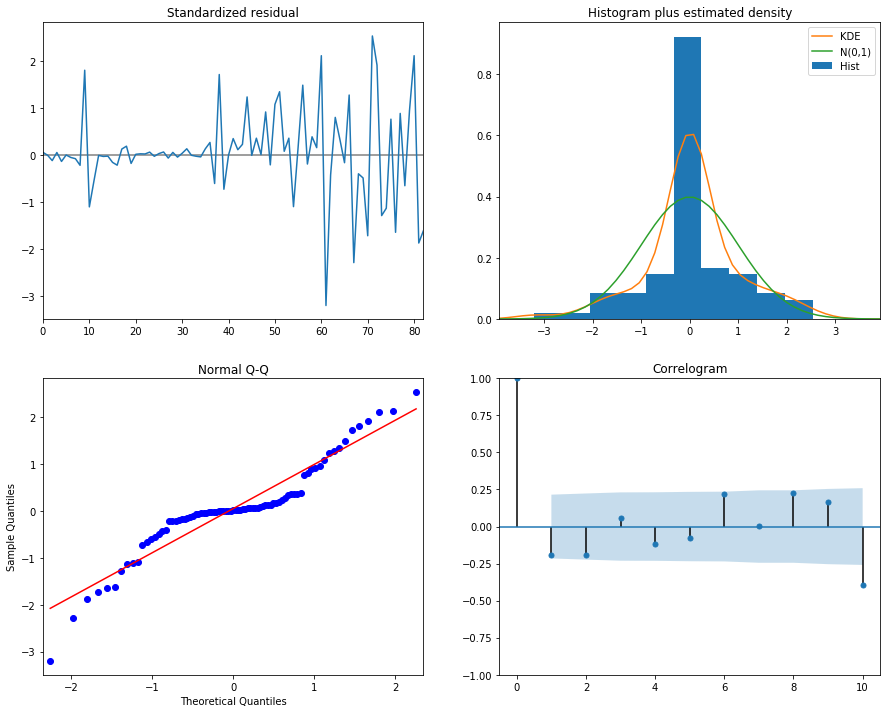

In [41]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

По графикам видно, что модель можно пробовать улучшать. Попробуем подобрать параметры получше.

In [42]:
p = range(0, 6)
d = range(0, 3)
q = range(0, 8)

pdq = list(itertools.product(p, d, q))

p = [0] 
d = [0, 1]
q = range(0, 5)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 0, 7)
SARIMAX: (0, 0, 2) x (0, 0, 0, 7)
SARIMAX: (0, 0, 2) x (0, 0, 1, 7)


In [43]:
warnings.filterwarnings("ignore") # отключает предупреждения
min_aic = 9999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(covid['Confirmed'].values[:-14],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results_ = mod.fit()
            if results_.aic < min_aic:
                min_aic = results_.aic
                print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results_.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC: 2292.8414367397095
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC: 2080.7138832866035
ARIMA(0, 0, 0)x(0, 0, 2, 7) - AIC: 1928.2474815457713
ARIMA(0, 0, 0)x(0, 0, 3, 7) - AIC: 1791.3081271596786
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC: 1746.051780240181
ARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC: 1607.7146289808295
ARIMA(0, 0, 0)x(0, 1, 3, 7) - AIC: 1453.5297247157825
ARIMA(0, 0, 1)x(0, 1, 3, 7) - AIC: 1416.811686812865
ARIMA(0, 0, 2)x(0, 1, 3, 7) - AIC: 1396.1992525314909
ARIMA(0, 0, 3)x(0, 1, 3, 7) - AIC: 1367.1632557867576
ARIMA(0, 0, 4)x(0, 1, 3, 7) - AIC: 1335.2528086102166
ARIMA(0, 0, 5)x(0, 1, 3, 7) - AIC: 1315.9539490291418
ARIMA(0, 0, 6)x(0, 1, 3, 7) - AIC: 1284.3768726226658
ARIMA(0, 0, 7)x(0, 1, 3, 7) - AIC: 1268.0157024002262
ARIMA(0, 1, 5)x(0, 1, 3, 7) - AIC: 1263.9253008884793
ARIMA(0, 1, 6)x(0, 1, 3, 7) - AIC: 1240.3873908022802
ARIMA(0, 1, 7)x(0, 1, 3, 7) - AIC: 1219.1600335428645
ARIMA(2, 1, 7)x(0, 1, 3, 7) - AIC: 1211.9587437216264
ARIMA(2, 2, 7)x(0, 1, 3, 7) - 

In [44]:
mod = sm.tsa.statespace.SARIMAX(covid['Confirmed'].values[:-14],order=[4,2,7],
                                seasonal_order=[0,1,3,7] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC: {results_opt.aic}')

AIC: 1204.2090293100268


Подбор параметров показал, что лучше показатели будут при ARIMA(4, 2, 7)x(0, 1, 3, 7) - AIC: 1204.2090293100268

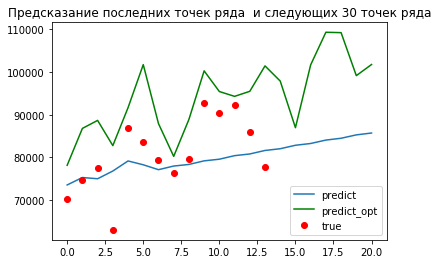

In [45]:
pred_dynamic = results.forecast(21)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(21)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(covid['Confirmed'].values[-14:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [46]:
print(results_opt.summary().tables[0],results_opt.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   95
Model:             SARIMAX(4, 2, 7)x(0, 1, 3, 7)   Log Likelihood                -587.105
Date:                           Wed, 13 May 2020   AIC                           1204.209
Time:                                   22:11:38   BIC                           1234.855
Sample:                                        0   HQIC                          1216.119
                                            - 95                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

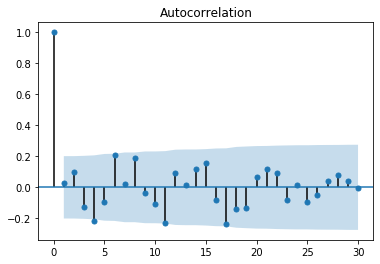

In [47]:
sm.graphics.tsa.plot_acf(results_opt.resid, lags=30)
plt.show()

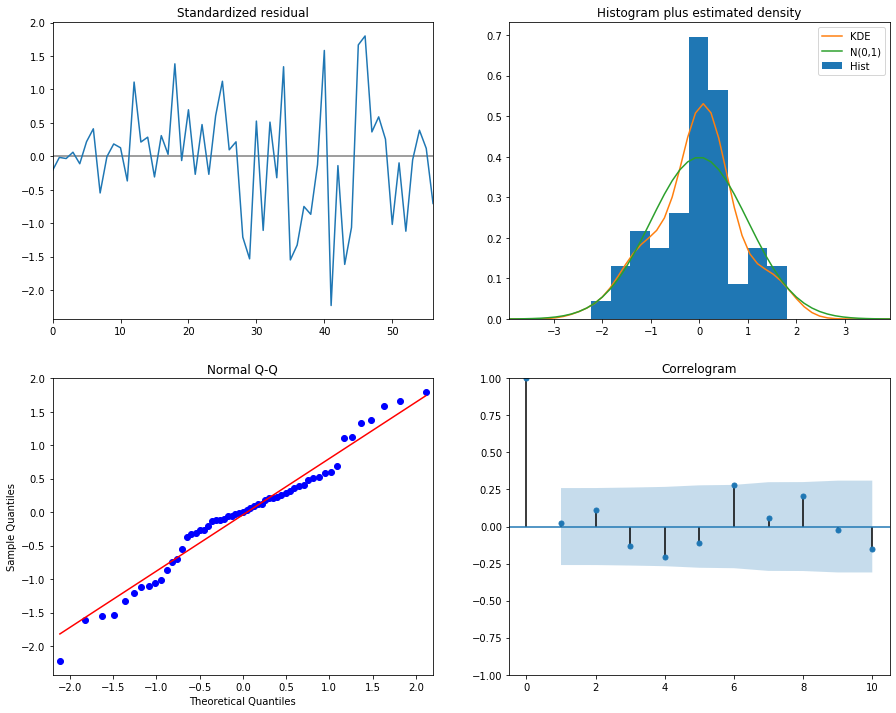

In [48]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()

Модель с оптимальными параметрами вроде бы лучше отражает колебания, но все равно как то не то. Попробуем убрать из модели сезонность, посмотрим что выйдет.

In [49]:
p = range(0, 6)
d = range(0, 3)
q = range(0, 8)

pdq = list(itertools.product(p, d, q))

In [50]:
min_aic = 9999999999
for param in pdq:
    try:

        mod = sm.tsa.statespace.SARIMAX(covid['Confirmed'].values[:-14],order=param,
                                    seasonal_order=(0, 0, 0, 0),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        results_ = mod.fit()
        if results_.aic < min_aic:
            min_aic = results_.aic
            print('ARIMA{} - AIC: {}'.format(param, results_.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC: 2292.8414367397095
ARIMA(0, 0, 1) - AIC: 2207.365595732479
ARIMA(0, 0, 2) - AIC: 2171.570914837372
ARIMA(0, 0, 3) - AIC: 2148.1238820680937
ARIMA(0, 0, 4) - AIC: 2128.9588382233874
ARIMA(0, 0, 5) - AIC: 2114.37881339069
ARIMA(0, 0, 6) - AIC: 2095.3404532178047
ARIMA(0, 0, 7) - AIC: 2076.5906589021533
ARIMA(0, 1, 0) - AIC: 1921.7868010977934
ARIMA(0, 1, 1) - AIC: 1901.1880530912238
ARIMA(0, 1, 2) - AIC: 1880.9702186227873
ARIMA(0, 1, 3) - AIC: 1863.35293895351
ARIMA(0, 1, 4) - AIC: 1838.1810303759667
ARIMA(0, 1, 5) - AIC: 1816.230154036551
ARIMA(0, 1, 6) - AIC: 1788.925667497713
ARIMA(0, 1, 7) - AIC: 1768.099513591867
ARIMA(0, 2, 7) - AIC: 1756.1723941177881
ARIMA(2, 2, 7) - AIC: 1754.4791076460972
ARIMA(4, 2, 7) - AIC: 1741.4944492457478


In [51]:
mod = sm.tsa.statespace.SARIMAX(covid['Confirmed'].values[:-14],order=[4,2,7],
                                seasonal_order=(0, 0, 0, 0) ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt_season_free = mod.fit()
print(f'AIC: {results_opt_season_free.aic}')

AIC: 1741.4944492457478


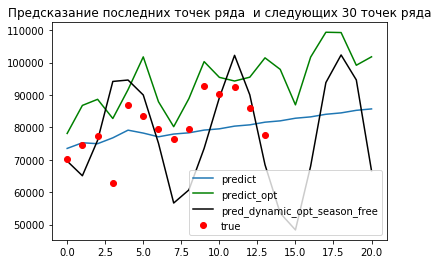

In [52]:
pred_dynamic = results.forecast(21)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(21)
pred_dynamic_opt_season_free = results_opt_season_free.forecast(21)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot(pred_dynamic_opt_season_free,'black', label='pred_dynamic_opt_season_free' )
#Отобразим истинный значения 
plt.plot(covid['Confirmed'].values[-14:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [53]:
print(results_opt_season_free.summary().tables[0],results_opt_season_free.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   95
Model:               SARIMAX(4, 2, 7)   Log Likelihood                -858.747
Date:                Wed, 13 May 2020   AIC                           1741.494
Time:                        22:12:19   BIC                           1770.806
Sample:                             0   HQIC                          1753.284
                                 - 95                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0411      0.100      0.411      0.6

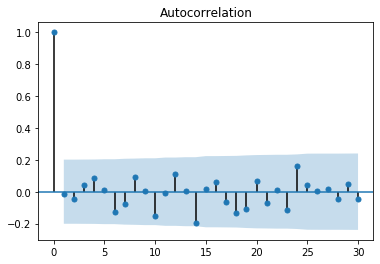

In [54]:
sm.graphics.tsa.plot_acf(results_opt_season_free.resid, lags=30)
plt.show()

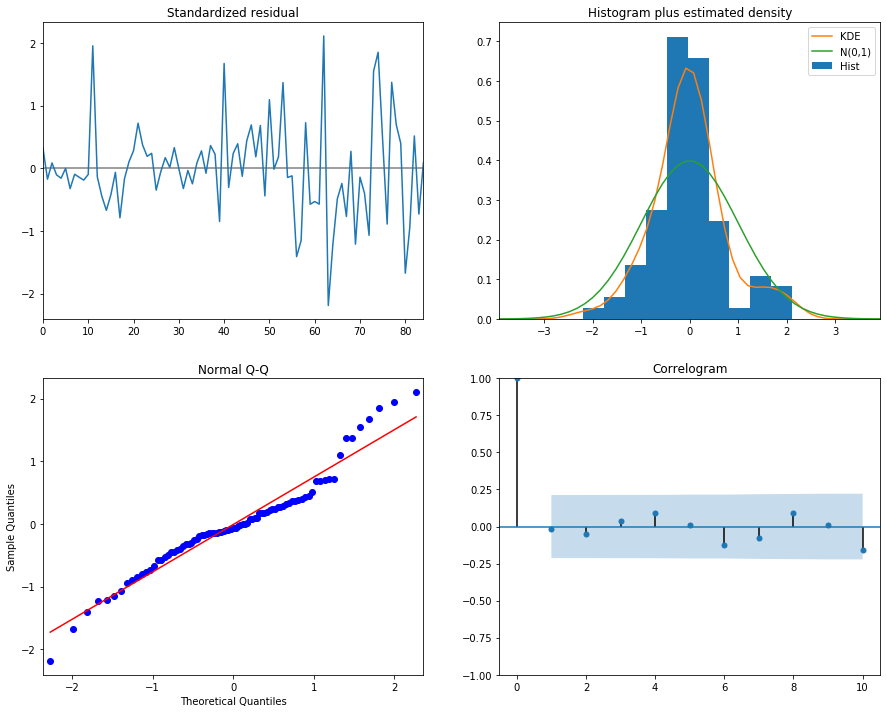

In [55]:
results_opt_season_free.plot_diagnostics(figsize=(15, 12))
plt.show()

Проверим остатки модели на стационарность.

In [56]:
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-3.3383469354386555, 0.013248995472145812, 5, 89, {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}, 1668.1533407042555)


In [57]:
adf_test = sm.tsa.stattools.adfuller(results.resid)
print(adf_test)

(-1.8161903245402526, 0.37245378700356, 10, 84, {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}, 1667.3147548575648)


In [58]:
adf_test = sm.tsa.stattools.adfuller(results_opt_season_free.resid)
print(adf_test)

(-9.74938027246315, 8.092370315998294e-17, 0, 94, {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}, 1652.3310106060774)


Оптимизированные модели с сезоном и без имеют стационарные остатки, проверим процент ошибки моделей.

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
er_result = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic[:14])
er_result_opt = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic_opt[:14])
er_result_opt_season_free = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic_opt_season_free[:14])

print('ошибка модели с учетом сезона:  ', er_result, '%')
print('ошибка оптимальной модели с учетом сезона:  ', er_result_opt, '%')
print('ошибка оптимальной модели без учета сезона:  ', er_result_opt_season_free, '%')

ошибка модели с учетом сезона:   7.3665919655725265 %
ошибка оптимальной модели с учетом сезона:   13.249791922423269 %
ошибка оптимальной модели без учета сезона:   13.285760857554726 %


Показатель AIC у оптимальной модель с учетом сезонности меньше, а значит по этому показателю она лучше, но процент ошибки у неоптимально модели ниже, что связано с тем, что неоптимальная модель сильнее сглажена и меньше учитывает межсуточные колебания. По итогу выберем модель __result_opt__

На последок проверим еще модель из коробки от Facebook. И посмотрим на ее показатель MAPE.

In [61]:
from fbprophet import Prophet


predictions = 7

# приводим dataframe к нужному формату
covid_fb = covid.iloc[:,0].reset_index()
covid_fb.columns = ['ds', 'y']

# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_covid = covid_fb[:-predictions] 

In [62]:
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(train_covid)

In [63]:
future = model.make_future_dataframe(periods=predictions)
forecast = model.predict(future)

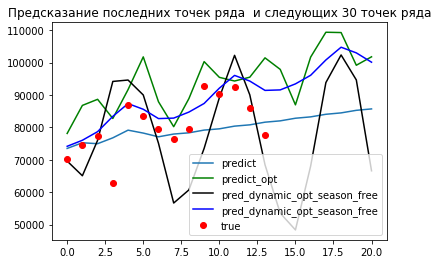

In [64]:
pred_dynamic = results.forecast(21)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(21)
pred_dynamic_opt_season_free = results_opt_season_free.forecast(21)
pred_fb_forecast = forecast.yhat.values[-21:]

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot(pred_dynamic_opt_season_free,'black', label='pred_dynamic_opt_season_free' )
plt.plot(pred_fb_forecast,'blue', label='pred_dynamic_opt_season_free' )

#Отобразим истинный значения 
plt.plot(covid['Confirmed'].values[-14:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [65]:
er_result = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic[:14])
er_result_opt = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic_opt[:14])
er_result_opt_season_free = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_dynamic_opt_season_free[:14])
er_fb = mean_absolute_percentage_error(y_true=covid['Confirmed'].values[-14:], y_pred=pred_fb_forecast[:14])

print('ошибка модели с учетом сезона:  ', er_result, '%')
print('ошибка оптимальной модели с учетом сезона:  ', er_result_opt, '%')
print('ошибка оптимальной модели без учета сезона:  ', er_result_opt_season_free, '%')
print('ошибка модели Facebook:  ', er_fb, '%')

ошибка модели с учетом сезона:   7.3665919655725265 %
ошибка оптимальной модели с учетом сезона:   13.249791922423269 %
ошибка оптимальной модели без учета сезона:   13.285760857554726 %
ошибка модели Facebook:   7.309580639990918 %


Модель от Facebook не сильно сглаживает, учитывает межсуточные колебания, имеет тренд, процент ошибки меньше моделей SARIMA.